Raw data not found. Generating and saving to 'simulated_data_lake/bronze/chip_logs.csv'...
Raw data saved.
SparkSession initialized successfully.
Loading data from simulated data lake: 'simulated_data_lake/bronze/chip_logs.csv'...
Data loaded successfully.

--- DataFrame Schema ---
root
 |-- timestamp: timestamp (nullable = true)
 |-- chip_id: string (nullable = true)
 |-- power_mw: integer (nullable = true)
 |-- temperature_c: double (nullable = true)
 |-- timing_errors: integer (nullable = true)


--- Analyzing Chip Performance ---

--- Top 10 Chips by Average Timing Errors ---
+-------+------------------+------------------+-------------------+
|chip_id|avg_power_mw      |avg_temperature_c |avg_timing_errors  |
+-------+------------------+------------------+-------------------+
|chip_43|5108.965174129353 |61.667263681592054|0.3283582089552239 |
|chip_0 |5000.444444444444 |60.3773015873016  |0.2804232804232804 |
|chip_21|5161.604060913705 |61.87299492385787 |0.27918781725888325|
|chip

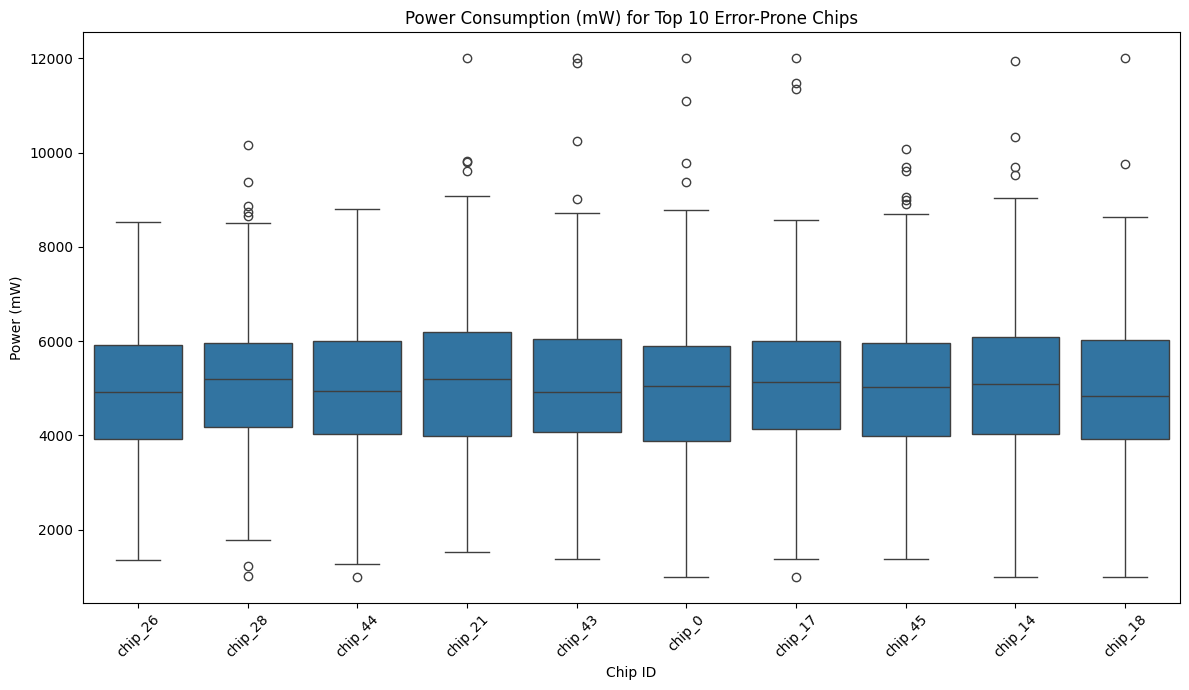

Displayed & Saved: Boxplot of power consumption as 'boxplot_power.png'.


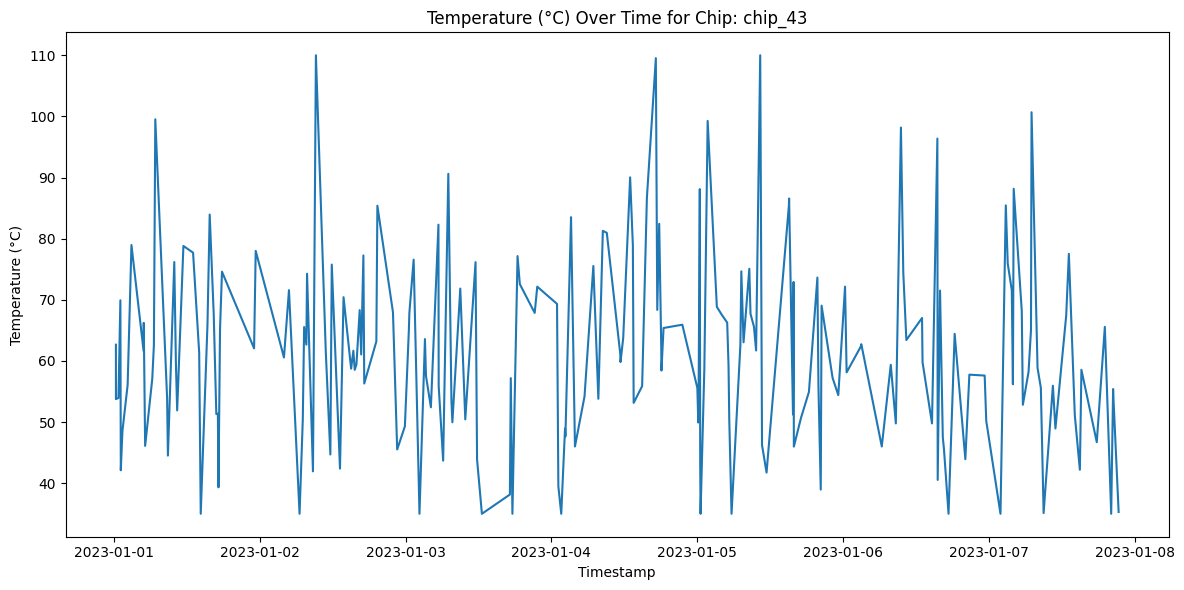

Displayed & Saved: Temperature line plot as 'lineplot_temperature.png'.


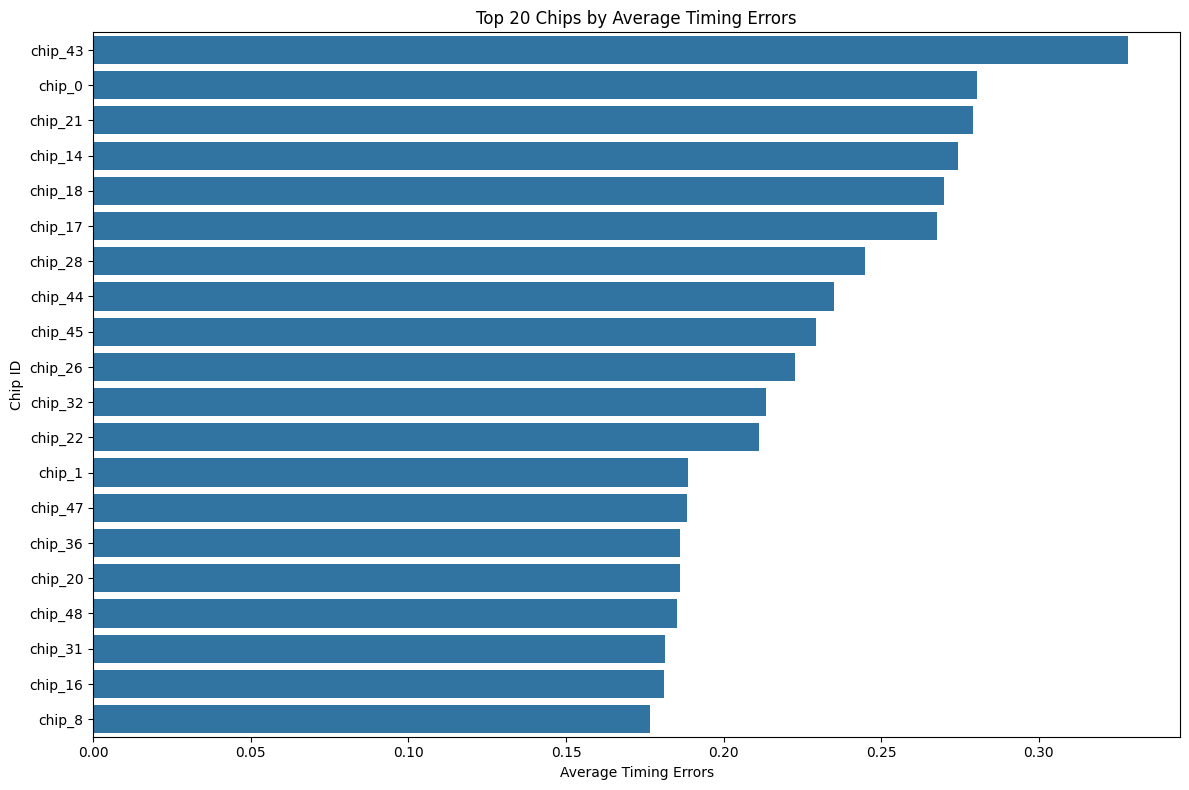

Displayed & Saved: Bar plot of average timing errors as 'barplot_errors.png'.


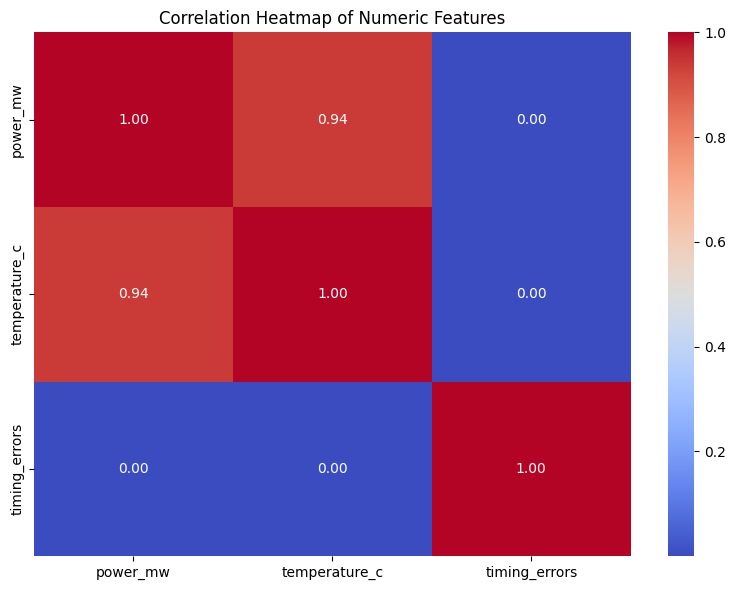

Displayed & Saved: Correlation heatmap as 'heatmap_correlation.png'.

SparkSession stopped.


In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, desc, stddev
from pyspark.sql.types import DoubleType, IntegerType, TimestampType
import datetime
import numpy as np

def generate_chip_data(num_rows=10000, num_chips=50, start_date=datetime.datetime(2023, 1, 1)):
    """Generates a Pandas DataFrame with synthetic chip performance data."""
    time_deltas = np.random.randint(1, 120, size=num_rows).cumsum()
    timestamps = [start_date + datetime.timedelta(seconds=int(delta)) for delta in time_deltas]
    chip_ids = [f"chip_{i}" for i in range(num_chips)]
    log_chip_ids = np.random.choice(chip_ids, size=num_rows)

    base_power = np.random.normal(loc=5000, scale=1500, size=num_rows)
    spike_indices = np.random.choice(num_rows, size=int(num_rows * 0.02), replace=False)
    base_power[spike_indices] *= np.random.uniform(1.5, 2.0, size=len(spike_indices))
    power_mw = np.clip(base_power, 1000, 12000).astype(int)

    base_temp = 60 + (power_mw - 5000) / 100
    noise = np.random.normal(0, 5, size=num_rows)
    temperature_c = base_temp + noise
    temp_spike_indices = np.random.choice(num_rows, size=int(num_rows * 0.01), replace=False)
    temperature_c[temp_spike_indices] += np.random.uniform(15, 25, size=len(temp_spike_indices))
    temperature_c = np.clip(temperature_c, 35, 110).round(2)

    timing_errors = np.zeros(num_rows, dtype=int)
    error_indices = np.random.choice(num_rows, size=int(num_rows * 0.05), replace=False)
    timing_errors[error_indices] = np.random.randint(1, 5, size=len(error_indices))
    # Add some > 5 errors to ensure the outlier condition is met
    high_error_indices = np.random.choice(num_rows, size=int(num_rows * 0.005), replace=False)
    timing_errors[high_error_indices] = np.random.randint(6, 10, size=len(high_error_indices))

    data = {'timestamp': timestamps, 'chip_id': log_chip_ids, 'power_mw': power_mw, 'temperature_c': temperature_c, 'timing_errors': timing_errors}
    return pd.DataFrame(data)

def main():
    """
    Initializes a Spark session, loads chip performance data,
    performs analysis, detects outliers, and visualizes the results.
    """
    # Simulate a simple data lake structure with local folders
    base_dir = "simulated_data_lake"
    bronze_path = os.path.join(base_dir, "bronze", "chip_logs.csv")
    silver_path = os.path.join(base_dir, "silver", "chip_analysis")

    os.makedirs(os.path.dirname(bronze_path), exist_ok=True)
    os.makedirs(os.path.dirname(silver_path), exist_ok=True)

    if not os.path.exists(bronze_path):
        print(f"Raw data not found. Generating and saving to '{bronze_path}'...")
        raw_df = generate_chip_data()
        raw_df.to_csv(bronze_path, index=False)
        print("Raw data saved.")

    try:
        spark = SparkSession.builder \
            .appName("ChipLogAnalysis_FullPipeline") \
            .master("local[*]") \
            .getOrCreate()
        print("SparkSession initialized successfully.")

        print(f"Loading data from simulated data lake: '{bronze_path}'...")
        df = spark.read.csv(bronze_path, header=True, inferSchema=True)
        print("Data loaded successfully.")

        # Cast columns to their proper types for analysis
        df = df.withColumn("power_mw", col("power_mw").cast(IntegerType())) \
               .withColumn("temperature_c", col("temperature_c").cast(DoubleType())) \
               .withColumn("timing_errors", col("timing_errors").cast(IntegerType())) \
               .withColumn("timestamp", col("timestamp").cast(TimestampType()))

        print("\n--- DataFrame Schema ---")
        df.printSchema()

        print("\n--- Analyzing Chip Performance ---")
        chip_performance = df.groupBy("chip_id") \
            .agg(
                avg("power_mw").alias("avg_power_mw"),
                avg("temperature_c").alias("avg_temperature_c"),
                avg("timing_errors").alias("avg_timing_errors")
            )
        top_error_chips = chip_performance.orderBy(desc("avg_timing_errors"))

        print("\n--- Top 10 Chips by Average Timing Errors ---")
        top_error_chips.show(10, truncate=False)

        print(f"\nWriting processed analysis data to Silver layer: '{silver_path}'")
        chip_performance.write.mode("overwrite").parquet(silver_path)
        print("Processed data saved in Parquet format.")

        print("\n--- Detecting Outliers ---")
        # .collect() brings the result to the driver, which is fine for summary stats
        power_stats = df.select(avg("power_mw").alias("mean_power"), stddev("power_mw").alias("stddev_power")).collect()[0]
        mean_power, stddev_power = power_stats["mean_power"], power_stats["stddev_power"]
        power_threshold = mean_power + (2 * stddev_power)

        outliers_df = df.filter(
            (col("power_mw") > power_threshold) |
            (col("temperature_c") > 90.0) |
            (col("timing_errors") > 5)
        )
        print("\n--- Outlier Chip Entries Found ---")
        outliers_df.show(truncate=False)

        print("\n--- Generating Visualizations ---")
        # Note: .toPandas() collects all data to the driver node. This is only safe for smaller datasets.

        top_10_chip_ids = [row.chip_id for row in top_error_chips.select("chip_id").limit(10).collect()]
        power_pd = df.filter(col("chip_id").isin(top_10_chip_ids)).select("chip_id", "power_mw").toPandas()

        plt.figure(figsize=(12, 7))
        sns.boxplot(x='chip_id', y='power_mw', data=power_pd)
        plt.title('Power Consumption (mW) for Top 10 Error-Prone Chips')
        plt.xlabel('Chip ID')
        plt.ylabel('Power (mW)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("boxplot_power.png")
        plt.show()
        print("Displayed & Saved: Boxplot of power consumption as 'boxplot_power.png'.")

        sample_chip_id = top_10_chip_ids[0]
        temp_pd = df.filter(col("chip_id") == sample_chip_id).select("timestamp", "temperature_c").toPandas()

        plt.figure(figsize=(12, 6))
        sns.lineplot(x='timestamp', y='temperature_c', data=temp_pd.sort_values('timestamp'))
        plt.title(f'Temperature (°C) Over Time for Chip: {sample_chip_id}')
        plt.xlabel('Timestamp')
        plt.ylabel('Temperature (°C)')
        plt.tight_layout()
        plt.savefig("lineplot_temperature.png")
        plt.show()
        print(f"Displayed & Saved: Temperature line plot as 'lineplot_temperature.png'.")

        top_20_errors_pd = top_error_chips.limit(20).toPandas()

        plt.figure(figsize=(12, 8))
        sns.barplot(x='avg_timing_errors', y='chip_id', data=top_20_errors_pd, orient='h')
        plt.title('Top 20 Chips by Average Timing Errors')
        plt.xlabel('Average Timing Errors')
        plt.ylabel('Chip ID')
        plt.tight_layout()
        plt.savefig("barplot_errors.png")
        plt.show()
        print("Displayed & Saved: Bar plot of average timing errors as 'barplot_errors.png'.")

        numeric_features_pd = df.select("power_mw", "temperature_c", "timing_errors").toPandas()
        corr_matrix = numeric_features_pd.corr()

        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap of Numeric Features')
        plt.tight_layout()
        plt.savefig("heatmap_correlation.png")
        plt.show()
        print("Displayed & Saved: Correlation heatmap as 'heatmap_correlation.png'.")

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        if 'spark' in locals() and spark.getActiveSession():
            spark.stop()
            print("\nSparkSession stopped.")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd

# Define the path to the Parquet file
parquet_file_path = "/content/simulated_data_lake/silver/chip_analysis/part-00000-93efb91f-bed7-4d57-93a7-e50cecf3d12d-c000.snappy.parquet"

# Read the Parquet file into a pandas DataFrame
chip_analysis_df = pd.read_parquet(parquet_file_path)

# Define the output Excel file path
excel_output_path = "chip_analysis.xlsx"

# Save the DataFrame to an Excel file
chip_analysis_df.to_excel(excel_output_path, index=False)

print(f"Chip analysis data saved to '{excel_output_path}' in Excel format.")

Chip analysis data saved to 'chip_analysis.xlsx' in Excel format.


In [3]:
pip install streamlit pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.7 MB/s eta 0:00:00


2025-07-24 13:32:10.116 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:32:10.118 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-07-24 13:32:10.121 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-07-24 13:32:10.122 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:32:10.300 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-24 13:32:10.300 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 13:32:10.302 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running 

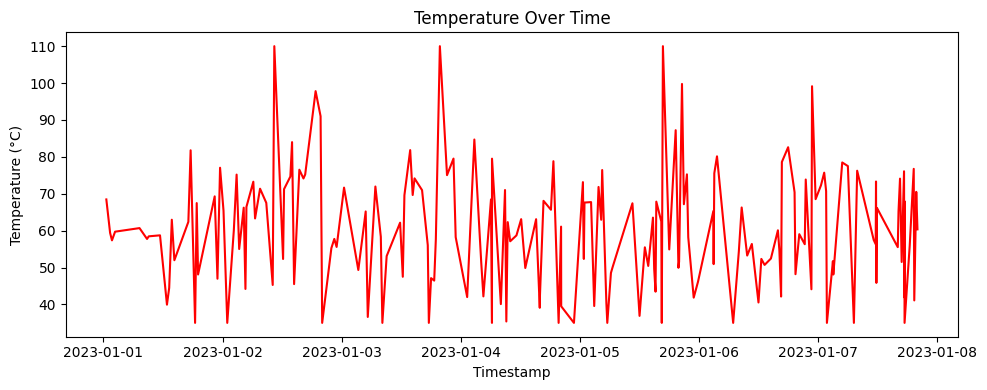

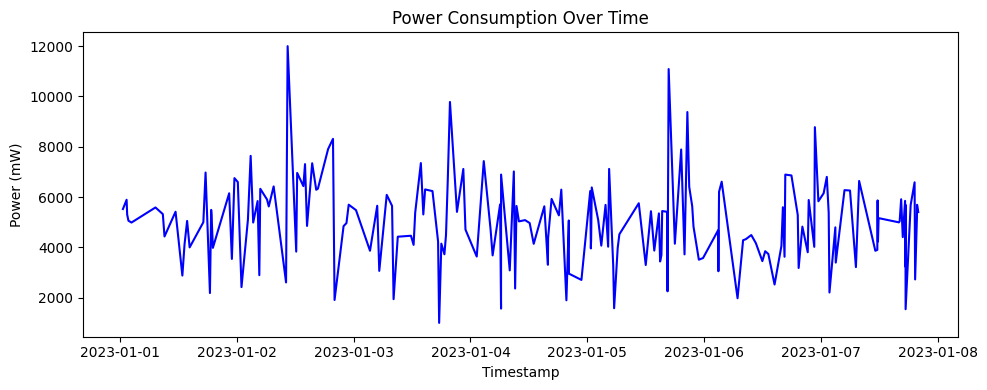

In [4]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Page Configuration ---
st.set_page_config(
    page_title="Chip Performance Dashboard",
    page_icon="🤖",
    layout="wide"
)

# --- Data Loading ---
# Use the simulated data lake path, assuming the main script has been run
DATA_FILE = os.path.join("simulated_data_lake", "bronze", "chip_logs.csv")

@st.cache_data
def load_data(filepath):
    """Loads the chip performance data from the specified CSV file."""
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    else:
        st.error(f"Data file not found at {filepath}. Please run the main EDA pipeline script first to generate the data.")
        return None

df = load_data(DATA_FILE)

# --- Main App ---
if df is not None:
    st.title("Chip Performance Dashboard")
    st.markdown("An interactive dashboard to analyze semiconductor chip performance logs.")

    # --- Sidebar for Filters ---
    st.sidebar.header("Filters")
    chip_ids = sorted(df["chip_id"].unique())
    selected_chip = st.sidebar.selectbox("Select a Chip ID:", chip_ids)

    # Filter data based on selection
    chip_data = df[df["chip_id"] == selected_chip].copy()

    # --- Main Content ---
    st.header(f"Analysis for: `{selected_chip}`")

    # Key Metrics
    avg_power = chip_data["power_mw"].mean()
    avg_temp = chip_data["temperature_c"].mean()
    avg_errors = chip_data["timing_errors"].mean()

    col1, col2, col3 = st.columns(3)
    col1.metric("Average Power (mW)", f"{avg_power:.2f}")
    col2.metric("Average Temperature (°C)", f"{avg_temp:.2f}")
    col3.metric("Total Timing Errors", f"{chip_data['timing_errors'].sum()}")

    st.markdown("---")

    # --- Charts ---
    st.subheader("Performance Charts")

    # Temperature over time
    fig1, ax1 = plt.subplots(figsize=(10, 4))
    sns.lineplot(data=chip_data, x="timestamp", y="temperature_c", ax=ax1, color='red')
    ax1.set_title("Temperature Over Time")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("Temperature (°C)")
    plt.tight_layout()
    st.pyplot(fig1)

    # Power over time
    fig2, ax2 = plt.subplots(figsize=(10, 4))
    sns.lineplot(data=chip_data, x="timestamp", y="power_mw", ax=ax2, color='blue')
    ax2.set_title("Power Consumption Over Time")
    ax2.set_xlabel("Timestamp")
    ax2.set_ylabel("Power (mW)")
    plt.tight_layout()
    st.pyplot(fig2)

    # Raw Data Viewer
    with st.expander("View Raw Data for Selected Chip"):
        st.dataframe(chip_data)

else:
    st.info("Awaiting data file generation...")